## 2.5 Transformadores y pipelines personalizados

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [35]:
df = pd.read_csv('pre_transformed_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


El dataset contiene columnas de tipo numérico y objeto. Anteriormente vimos que las columnas de tipo objeto no necesitaban limpieza (solo la codificación). Hay una columna numérica (`TotalCharges`) que tiene valores nulos.

### Antes de continuar
Codificamos la variable objetivo manualmente para que sea numérica.

In [36]:
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

Vamos a crear un transformador que procese lo siguiente:
- Para columnas numéricas:
	- Imputar los valores nulos con la mediana de la columna (usando `SimpleImputer`).
	- Escalar los valores (usando `RobustScaler`).
- Para columnas de tipo objeto:
	- Codificar las columnas con `OneHotEncoder`.

In [37]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

class CustomPreprocessor(BaseEstimator, TransformerMixin):
	def __init__(self):
		self.pipeline = None
		self.feature_names = None

	def fit(self, X, y=None):
		X = X.copy()
		
		# Detectar columnas numéricas y categóricas
		self.num_cols = X.select_dtypes(exclude=['object']).columns.tolist()
		self.cat_cols = X.select_dtypes(include=['object']).columns.tolist()

		# Pipeline para numéricas
		num_pipeline = Pipeline([
				('imputer', SimpleImputer(strategy='median')),
				('scaler', RobustScaler())
		])

		# Pipeline para categóricas
		cat_pipeline = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

		# Combinación de pipelines
		self.pipeline = ColumnTransformer([
				('num', num_pipeline, self.num_cols),
				('cat', cat_pipeline, self.cat_cols)
		])

		# Ajustar pipeline
		self.pipeline.fit(X)

		# Guardar nombres de columnas finales
		cat_feature_names = self.pipeline.named_transformers_['cat'].get_feature_names_out(self.cat_cols)
		self.feature_names = self.num_cols + list(cat_feature_names)
		
		return self

	def transform(self, X, y=None):
		X = X.copy()
		X_transformed = self.pipeline.transform(X)
		return pd.DataFrame(X_transformed, columns=self.feature_names, index=X.index)


## 3. **Ensemble Models**

- **Bagging**: Implement a bagging method, such as Random Forest or Bagging Classifier.
- **Boosting**: Use CatBoost as a boosting algorithm.
- **Stacking Classifier**: Build a stacking classifier with at least two base models and one meta-model.
- **Voting Classifier**: Implement a voting classifier with both hard and soft voting.

### Funciones auxiliares

In [38]:
from sklearn.model_selection import train_test_split

# Construcción de una función que realice el particionado completo
def train_val_test_split(df, rstate=42, shuffle=True, stratify=None):
	strat = df[stratify] if stratify else None
	train_set, test_set = train_test_split(
		df, test_size=0.4, random_state=rstate, shuffle=shuffle, stratify=strat)
	strat = test_set[stratify] if stratify else None
	val_set, test_set = train_test_split(
		test_set, test_size=0.5, random_state=rstate, shuffle=shuffle, stratify=strat)
	return (train_set, val_set, test_set)

# Construcción de una función que separe las etiquetas del resto de las columnas
def remove_labels(df, label_name):
	X = df.drop(label_name, axis=1)
	y = df[label_name].copy()
	return (X, y)

Estamos trabajando con el 60% de los datos para entrenamiento, y el 40% restante se divide en mitades para validación y test.

### Split y transformación de los datos

In [39]:
# Split de los datos en train, val y test
train_set, val_set, test_set = train_val_test_split(df, stratify='Churn')

# Separación de las etiquetas
X_train, y_train = remove_labels(train_set, 'Churn')
X_val, y_val = remove_labels(val_set, 'Churn')
X_test, y_test = remove_labels(test_set, 'Churn')

# Preprocesamiento de los datos
preprocessor = CustomPreprocessor()
preprocessor.fit(X_train)
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)
X_test_transformed = preprocessor.transform(X_test)

## 3.1 Clasificador simple (regresión logística)

### Ajuste de hiperparámetros y entrenamiento de modelo

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

log_reg = LogisticRegression(max_iter=1000)

# Espacio de búsqueda
param_grid = {
	'penalty': ['l2'],
	'C': [0.01, 0.1, 1, 10, 100],
	'solver': ['lbfgs', 'saga']
}

# Búsqueda con validación cruzada
grid_log = GridSearchCV(
	estimator=log_reg,
	param_grid=param_grid,
	scoring='roc_auc',
	cv=5,
	n_jobs=-1,
	verbose=1
)

# Entrenamiento del modelo con mejores hiperparámetros
grid_log.fit(X_train_transformed, y_train)
best_log = grid_log.best_estimator_
print("Mejores hiperparámetros:", grid_log.best_params_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Mejores hiperparámetros: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}


## 3.2 Bagging (Random Forest)
### Ajuste de hiperparámetros y entrenamiento de modelo

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

rf = RandomForestClassifier(random_state=42)

# Espacio de búsqueda
param_grid = {
	'n_estimators': [100, 200],
	'max_depth': [None, 10, 20],
	'min_samples_split': [2, 5],
	'min_samples_leaf': [1, 2],
	'bootstrap': [True, False]
}

grid_rf = GridSearchCV(
	estimator=rf,
	param_grid=param_grid,
	scoring='roc_auc',
	cv=5,
	n_jobs=-1,
	verbose=1
)

grid_rf.fit(X_train_transformed, y_train)
best_rf = grid_rf.best_estimator_
print("Mejores hiperparámetros:", grid_rf.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Mejores hiperparámetros: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


## 3.3 Boosting (CatBoost)
### Ajuste de hiperparámetros y entrenamiento de modelo

In [ ]:
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV

cat = CatBoostClassifier(
	verbose=0,
	random_state=42,
	cat_features=None
)

# Espacio de hiperparámetros
param_dist = {
	'iterations': [100, 300, 500],
	'learning_rate': [0.01, 0.05, 0.1],
	'depth': [4, 6, 8],
	'l2_leaf_reg': [1, 3, 5, 7],
	'border_count': [32, 64, 128]
}

random_search_cat = RandomizedSearchCV(
	estimator=cat,
	param_distributions=param_dist,
	n_iter=20,
	scoring='roc_auc',
	cv=5,
	n_jobs=-1,
	verbose=1,
	random_state=42
)

random_search_cat.fit(X_train_transformed, y_train)
best_cat = random_search_cat.best_estimator_
print("Mejores hiperparámetros:", random_search_cat.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejores hiperparámetros: {'learning_rate': 0.05, 'l2_leaf_reg': 7, 'iterations': 100, 'depth': 4, 'border_count': 128}


## 3.4 Stacking Classifier
### Entrenamiento de modelo

In [ ]:
from sklearn.ensemble import StackingClassifier

# Usamos RF y Catboost ya tuneados como base estimators
base_estimators = [
	('random_forest', best_rf),
	('catboost', best_cat)
]

# Meta-modelo ya tuneado
meta_model = best_log

stack_clf = StackingClassifier(
	estimators=base_estimators,
	final_estimator=meta_model,
	cv=5,
	n_jobs=-1
)

# Entrenamiento
stack_clf.fit(X_train_transformed, y_train)

StackingClassifier(cv=5,
                   estimators=[('random_forest',
                                RandomForestClassifier(max_depth=10,
                                                       min_samples_leaf=2,
                                                       n_estimators=200,
                                                       random_state=42)),
                               ('catboost',
                                <catboost.core.CatBoostClassifier object at 0x0000019F06281B50>)],
                   final_estimator=LogisticRegression(C=100, max_iter=1000,
                                                      solver='saga'),
                   n_jobs=-1)

## 3.5 Hard Voting Classifier
### Entrenamiento de modelo

In [ ]:
from sklearn.ensemble import VotingClassifier

voting_hard = VotingClassifier(
	estimators=[
		('rf', best_rf),
		('cat', best_cat),
		('log', best_log)
	],
	voting='hard',
	n_jobs=-1
)

voting_hard.fit(X_train_transformed, y_train)

VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=2,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x0000019F06281B50>),
                             ('log',
                              LogisticRegression(C=100, max_iter=1000,
                                                 solver='saga'))],
                 n_jobs=-1)

## 3.6 Soft Voting Classifier
### Entrenamiento de modelo

In [46]:
voting_soft = VotingClassifier(
	estimators=[
		('rf', best_rf),
		('cat', best_cat),
		('log', best_log)
	],
	voting='soft',
	n_jobs=-1
)

voting_soft.fit(X_train_transformed, y_train)


VotingClassifier(estimators=[('rf',
                              RandomForestClassifier(max_depth=10,
                                                     min_samples_leaf=2,
                                                     n_estimators=200,
                                                     random_state=42)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x0000019F06281B50>),
                             ('log',
                              LogisticRegression(C=100, max_iter=1000,
                                                 solver='saga'))],
                 n_jobs=-1, voting='soft')

# 4. **Model Evaluation:**

Train and evaluate each ensemble model, along with a single classifier (such as decision tree, logistic regression, or SVM) to verify if ensemble techniques improve performance. Use the following metrics to evaluate the models:
- Accuracy
- AUC (Area Under the Curve)
- Confusion Matrix
- F1-Score

Select the best ensemble model based on the above metrics

## 4.1 Funciones para graficar las métricas

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# Función para evaluar accuracia, AUC y F1-Score de un modelo
def model_eval(modelo, X_val, y_val=y_val):
	y_pred = modelo.predict(X_val)
	
	try:
		y_proba = modelo.predict_proba(X_val)[:, 1]
		auc = roc_auc_score(y_val, y_proba)
	except:
		auc = 0

	return {
		'Accuracy': accuracy_score(y_val, y_pred),
		'AUC': auc,
		'F1-Score': f1_score(y_val, y_pred),
	}

In [ ]:
# Función para evaluar todos los modelos
def all_models_eval(models):
	results = {}
	for name, model in models.items():
		results[name] = model_eval(model[0], model[1])
	results = pd.DataFrame(results)
	return results.loc[['Accuracy', 'AUC', 'F1-Score']]

In [ ]:
# Función para graficar las métricas de los modelos
def plot_metrics(models):
	results = all_models_eval(models)
	results.plot(kind='bar', figsize=(10, 6))
	plt.title('Comparación de Rendimiento')
	plt.ylabel('Valor de Métrica')
	plt.xlabel('Métrica')
	plt.grid(axis='y')
	plt.xticks(rotation=0)
	plt.legend(title='Modelo', bbox_to_anchor=(1.05, 1), loc='upper left')
	plt.tight_layout()
	plt.show()

## 4.2 Evaluación de modelos

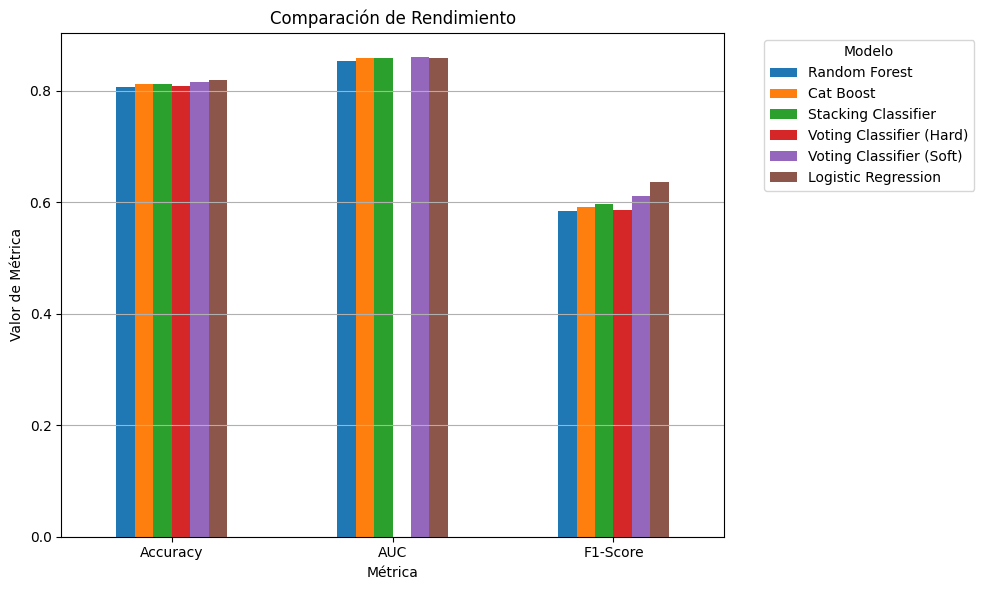

In [152]:
# Diccionario de modelos
modelos = {
	'Random Forest': [best_rf, X_val_transformed],
	'Cat Boost': [best_cat, X_val_transformed],
	'Stacking Classifier': [stack_clf, X_val_transformed],
	'Voting Classifier (Hard)': [voting_hard, X_val_transformed],
	'Voting Classifier (Soft)': [voting_soft, X_val_transformed],
	'Logistic Regression': [best_log, X_val_transformed]
}

plot_metrics(modelos)

Tras evaluar todos los modelos entrenados utilizando el conjunto de validación y las métricas **Accuracy**, **AUC** y **F1-Score**, se concluye que el **clasificador individual basado en Regresión Logística** es la mejor opción para este problema.

Aunque los modelos de ensamble como Bagging, Boosting, Stacking y Voting ofrecen un rendimiento competitivo, **la Regresión Logística presenta métricas similares o incluso superiores**, especialmente en **F1-Score y Accuracy**, mientras que mantiene un menor costo computacional y mayor interpretabilidad.

Por lo tanto, considerando tanto el desempeño como la eficiencia, se selecciona el **Single Classifier (Logistic Regression)** como el modelo final.

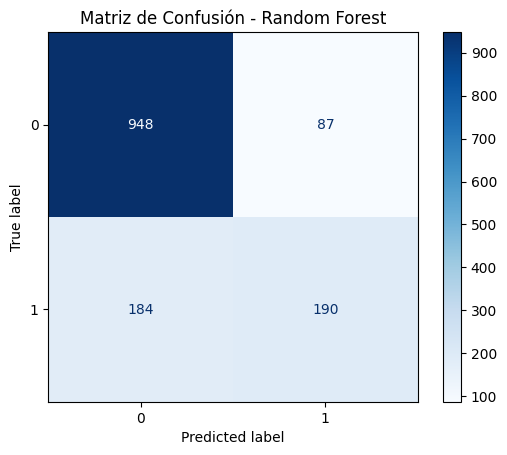

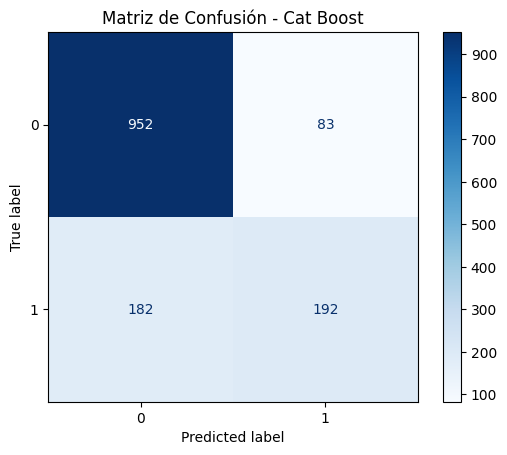

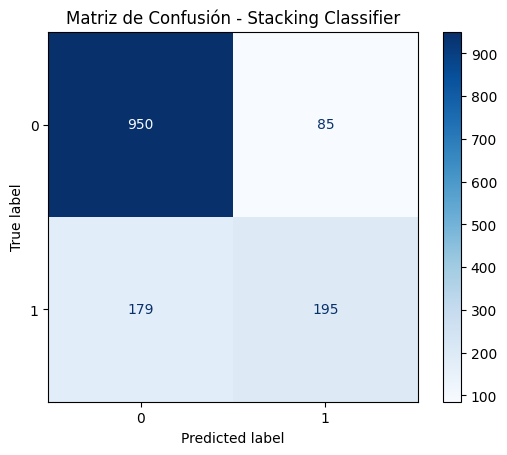

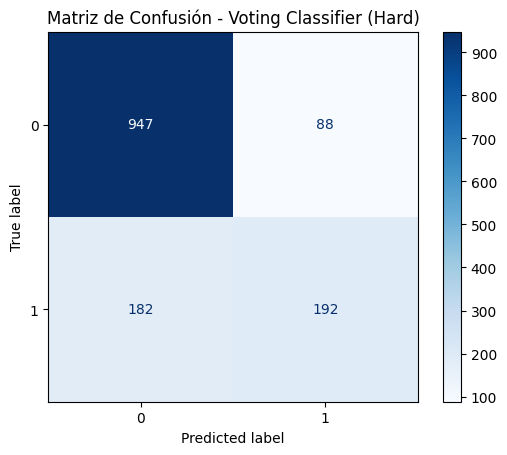

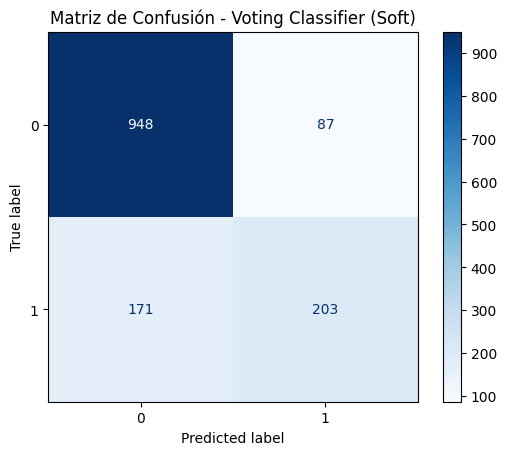

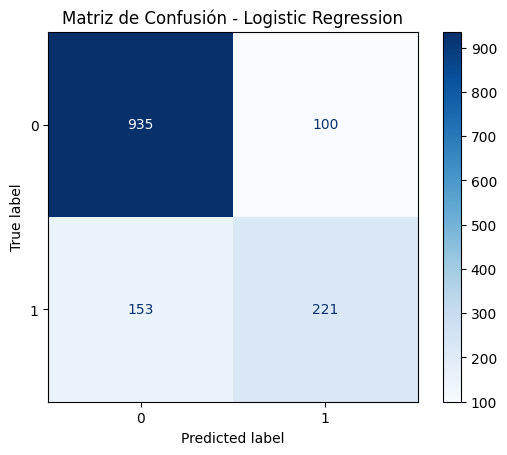

In [153]:
# Veamos las matrices de confusión de los modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def plot_confusion_matrix(model, X_val, y_val, model_name):
	y_pred = model.predict(X_val)
	cm = confusion_matrix(y_val, y_pred)
	disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
	disp.plot(cmap=plt.cm.Blues)
	plt.title(f'Matriz de Confusión - {model_name}')
	plt.show()

# Graficamos las matrices de confusión
for name, model in modelos.items():
	plot_confusion_matrix(model[0], model[1], y_val, name)

Tras analizar las matrices de confusión de todos los modelos evaluados, se observa que los resultados son muy similares entre sí. Las diferencias en los conteos de verdaderos positivos, verdaderos negativos, falsos positivos y falsos negativos son mínimas y no representan un cambio significativo en el comportamiento del modelo.

Por lo tanto, se concluye que **la matriz de confusión no aporta información adicional decisiva para diferenciar los modelos**, y la selección del mejor modelo puede sustentarse de forma más clara mediante métricas agregadas como **Accuracy, AUC y F1-Score**, junto con consideraciones de eficiencia computacional e interpretabilidad.

*Se puede notar el favorecimiento hacia la clase mayoritaria, ya que los valores de los verdaderos positivos no difieren mucho de los falsos positivos y falsos negativos*.

# **5. Class Balancing with SMOTE (Best Model Only)**

- Apply SMOTE (Synthetic Minority Over-sampling Technique) to the dataset if it is imbalanced.
- Use the balanced dataset to retrain the best ensemble model.
- Train the best ensemble model with and without data balancing, and compare the results to determine the impact of balancing on model performance.
- Describe how the application of SMOTE affected the class distribution and justify its use.

### Aplicamos SMOTE y visualizamos la distribución de clases

In [ ]:
from imblearn.over_sampling import SMOTE

# Aplicar SMOTE solo a los datos de entrenamiento
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_transformed, y_train)

Distribución original: [3104 1121]
Distribución SMOTE:    [3104 3104]


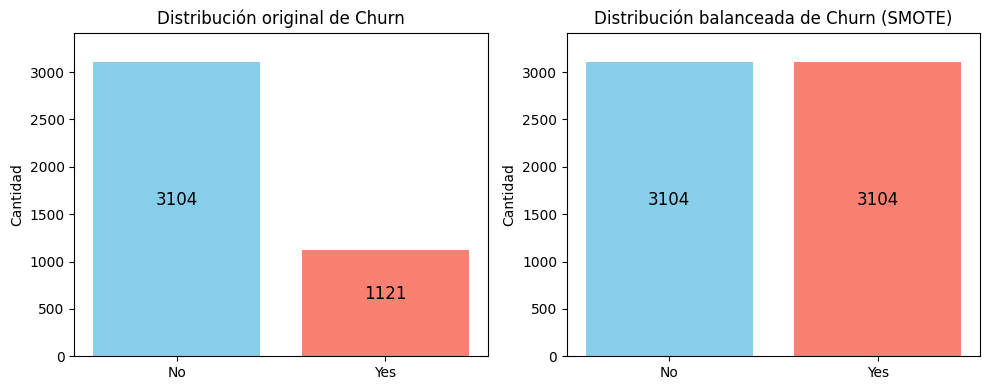

In [76]:
labels = ['No', 'Yes']

# Conteos originales y balanceados
counts_original = np.bincount(y_train)
counts_smote = np.bincount(y_train_smote)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Distribución original
bars0 = axes[0].bar(labels, counts_original, color=['skyblue', 'salmon'])
axes[0].set_title('Distribución original de Churn')
axes[0].set_ylabel('Cantidad')
axes[0].set_ylim(0, max(counts_original.max(), counts_smote.max()) * 1.1)
for bar, count in zip(bars0, counts_original):
	axes[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, str(count),
								ha='center', va='bottom', fontsize=12)

# Distribución balanceada (SMOTE)
bars1 = axes[1].bar(labels, counts_smote, color=['skyblue', 'salmon'])
axes[1].set_title('Distribución balanceada de Churn (SMOTE)')
axes[1].set_ylabel('Cantidad')
axes[1].set_ylim(0, max(counts_original.max(), counts_smote.max()) * 1.1)
for bar, count in zip(bars1, counts_smote):
	axes[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height() / 2, str(count),
								ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

Las clases fueron balanceadas exitosamente.

### Entrenamos Regresión Logística con SMOTE

In [77]:
# Usamos los mismos hiperparámetros del mejor modelo encontrado (best_log)
from sklearn.linear_model import LogisticRegression

logreg_smote = LogisticRegression(
    C=best_log.C,
    penalty=best_log.penalty,
    solver=best_log.solver,
    max_iter=1000,
    random_state=42
)

logreg_smote.fit(X_train_smote, y_train_smote)

LogisticRegression(C=100, max_iter=1000, random_state=42, solver='saga')

### Evaluación de modelos con SMOTE y sin SMOTE

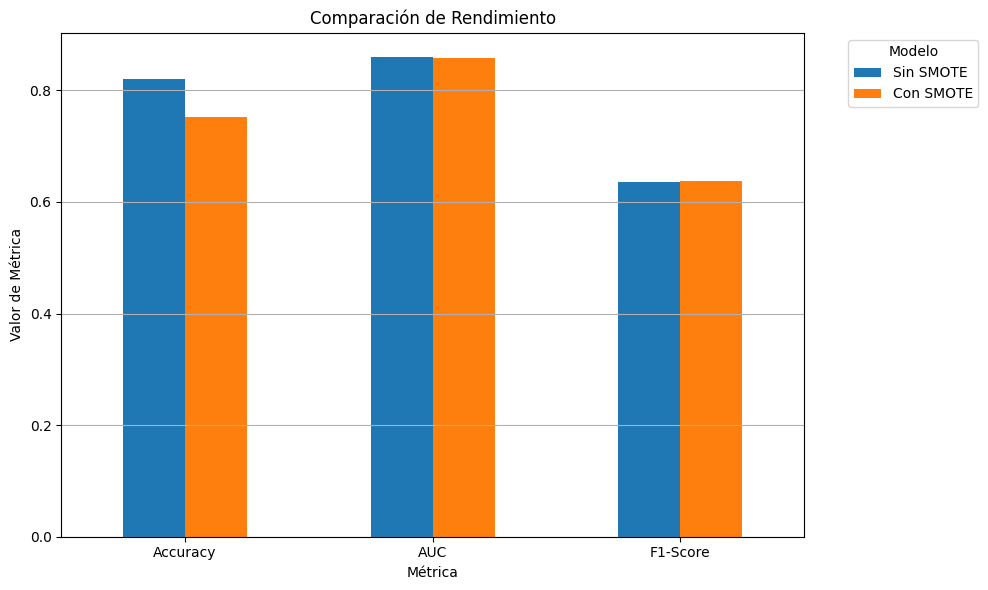

In [147]:
# Diccionario de modelos
modelos = {
	'Sin SMOTE': [best_log, X_val_transformed],
	'Con SMOTE': [logreg_smote, X_val_transformed],
}

plot_metrics(modelos)

### Impacto del Balanceo de Clases con SMOTE en Regresión Logística

Se aplicó la técnica de sobremuestreo **SMOTE** para balancear el conjunto de entrenamiento y se reentrenó el mejor modelo (Regresión Logística con hiperparámetros optimizados).

Al comparar el rendimiento del modelo **con y sin SMOTE**, se observa lo siguiente:

- La **Accuracy disminuyó notablemente** después de aplicar SMOTE.
- La **AUC** se mantuvo prácticamente igual, indicando que la capacidad de discriminación entre clases no se vio afectada.
- El **F1-Score aumentó ligeramente**, lo que indica una pequeña mejora en el balance entre precisión y recall para la clase minoritaria.

A pesar de esa mejora marginal en F1-Score, la pérdida en Accuracy es significativa, y dado que el modelo sin SMOTE ya tenía un rendimiento robusto y balanceado entre métricas, se concluye que **el modelo entrenado sin SMOTE presenta un mejor desempeño general y es el seleccionado como modelo final.** De esta forma, se mantiene un enfoque más conservador y eficiente, evitando la complejidad adicional que introduce el balanceo de clases sin una mejora sustancial en las métricas clave.

# **6. Feature Importance Analysis with the Best Model**

- Use Random Forest to identify the most important features of the dataset.
- Select the most relevant features and justify your choice (e.g., based on the importance score).
- Retrain the best ensemble model using only the most important features and calculate the training time. 
- Compare the performance and training time with the original model that used all features.
- Apply Hyperband to train the model with the most important features. Please use a table to show the values used for Hyperband.

## 6.1 Análisis de Importancia de Características

In [87]:
from sklearn.ensemble import RandomForestClassifier

rf_importancia = RandomForestClassifier(n_estimators=100, random_state=42)
rf_importancia.fit(X_train_transformed, y_train)

RandomForestClassifier(random_state=42)

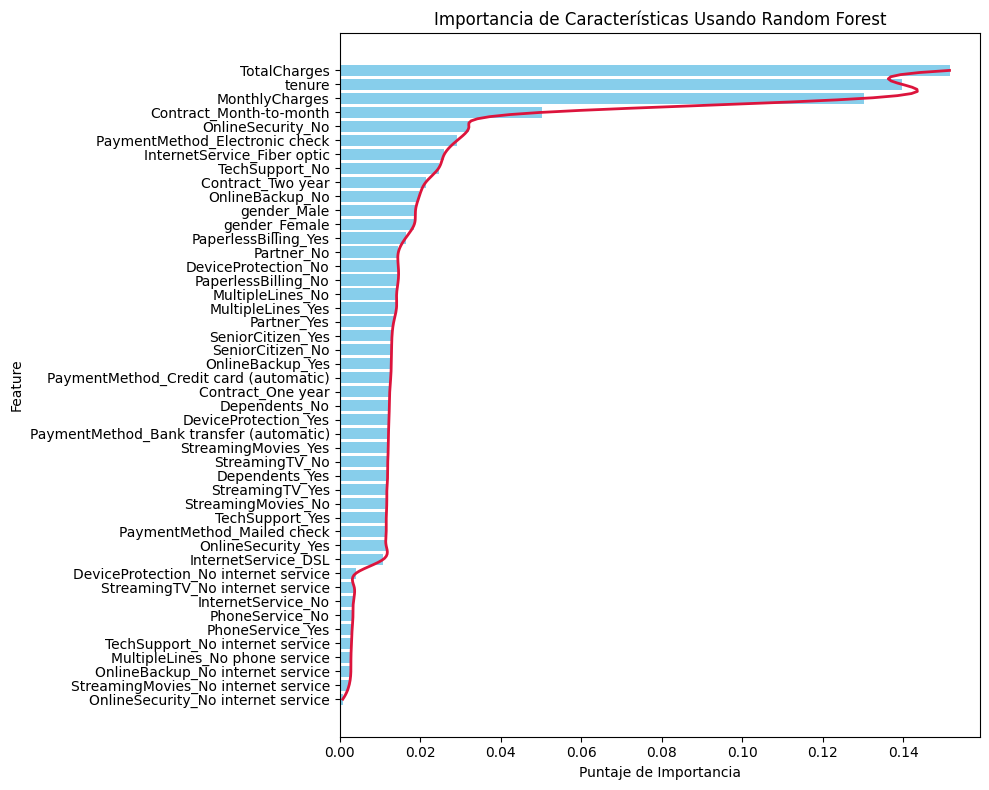

In [ ]:
from scipy.interpolate import make_interp_spline

# Obtener importancias
importancias = rf_importancia.feature_importances_
nombres = X_train_transformed.columns

# DataFrame ordenado
df_importancia = pd.DataFrame({'Feature': nombres, 'Importance': importancias})
df_importancia = df_importancia.sort_values(by='Importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, 8))
plt.barh(df_importancia['Feature'], df_importancia['Importance'], color='skyblue')

# Línea suave sobre las alturas de las barras
x = np.arange(len(df_importancia))
y = df_importancia['Importance'].values

# Crear puntos para la curva suave
if len(x) > 3:
    x_smooth = np.linspace(x.min(), x.max(), 300)
    spline = make_interp_spline(x, y, k=3)
    y_smooth = spline(x_smooth)
    plt.plot(y_smooth, x_smooth, color='crimson', linewidth=2)
else:
    plt.plot(y, x, color='crimson', linewidth=2)

plt.title('Importancia de Características Usando Random Forest')
plt.xlabel('Puntaje de Importancia')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Selección de las características más relevantes

Al analizar la gráfica de importancia generada, se observa un **descenso abrupto** en los puntajes de importancia después de las primeras 5 variables, lo cual indica un punto natural de corte. Estas primeras 5 características **concentran la mayor proporción del poder predictivo**, por lo que se seleccionan como las más relevantes.

#### Variables Seleccionadas:

1. **TotalCharges:** Representa el monto total cobrado al cliente desde que se unió al servicio. Es un fuerte indicador de la duración y valor del cliente.  
2. **tenure:** Número de meses que el cliente ha estado con la compañía. Los clientes con menor tenure tienen mayor probabilidad de abandonar el servicio, como se evidenció en el EDA.  
3. **MonthlyCharges:** Monto mensual que paga el cliente. Se relaciona con la percepción de valor o costo del servicio.  
4. **Contract_Month-to-month:** Indica si el cliente está en un contrato mensual. Esta modalidad suele tener mayor churn, ya que no implica compromiso a largo plazo.  
5. **OnlineSecurity_No:** Clientes que no tienen seguridad en línea. La falta de servicios de valor agregado puede aumentar la insatisfacción.

Estas variables no solo presentan **los puntajes de importancia más altos**, sino que además tienen un **claro significado interpretativo** en el contexto del problema de churn.

## 6.2 Entrenamiento del modelo con las características más importantes

In [115]:
# Seleccionar las 5 features más importantes
top_5_features = df_importancia['Feature'].head(5).tolist()

# Subconjuntos reducidos
X_train_reduced = X_train_transformed[top_5_features]
X_val_reduced = X_val_transformed[top_5_features]

In [116]:
from sklearn.linear_model import LogisticRegression
import time

# Crear nuevo modelo con mismos hiperparámetros
logreg_reduced = LogisticRegression(
	C=best_log.C,
	penalty=best_log.penalty,
	solver=best_log.solver,
	max_iter=1000,
	random_state=42
)

# Medir tiempo de entrenamiento
start_time = time.time()
logreg_reduced.fit(X_train_reduced, y_train)
train_time_reduced = time.time() - start_time

print(f"Tiempo de entrenamiento con 5 features: {train_time_reduced:.4f} segundos")

Tiempo de entrenamiento con 5 features: 0.0176 segundos


In [117]:
# Medimos el tiempo de entrenamiento con todas las features
start_time = time.time()

logreg_full = LogisticRegression(
	C=best_log.C,
	penalty=best_log.penalty,
	solver=best_log.solver,
	max_iter=1000,
	random_state=42
)
logreg_full.fit(X_train_transformed, y_train)

train_time_full = time.time() - start_time
print(f"Tiempo de entrenamiento con todas las features: {train_time_full:.4f} segundos")

Tiempo de entrenamiento con todas las features: 0.8887 segundos


In [118]:
# Comparar tiempos de entrenamiento
print(f"Reducción de tiempo: {train_time_full - train_time_reduced:.4f} segundos")

Reducción de tiempo: 0.8711 segundos


## 6.3 Comparación de métricas

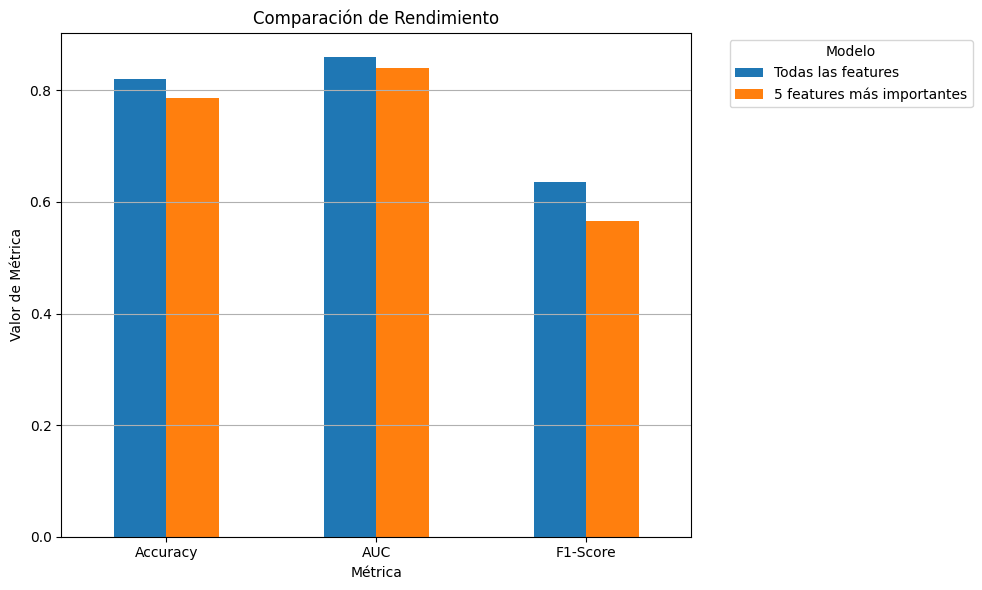

In [148]:
# Diccionario de modelos
modelos = {
	'Todas las features': [best_log, X_val_transformed],
	'5 features más importantes': [logreg_reduced, X_val_reduced],
}

plot_metrics(modelos)

### Comparación entre Modelo Completo y Modelo Reducido

| Métrica     | Modelo Completo | Modelo Reducido |
|-------------|------------------|------------------|
| Accuracy    | Más alto         | Ligeramente menor |
| AUC         | Más alto         | Muy similar       |
| F1-Score    | Más alto         | Inferior          |

Aunque el modelo reducido presenta una mejora en eficiencia con un tiempo de entrenamiento de apenas **0.0176 segundos**, frente a **0.8887 segundos** del modelo completo, esta ganancia **no justifica la pérdida de rendimiento**.

Por lo tanto, el **modelo completo con todas las características** ofrece **mejor rendimiento global** sin un costo computacional significativo, manteniendo además su interpretabilidad y estabilidad.

## 6.4 Aplicación de Hyperband al modelo de features importantes

In [126]:
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

# Grid de búsqueda
param_grid = {
	'C': [0.001, 0.01, 0.1, 1, 10],
	'penalty': ['l2'],
	'solver': ['lbfgs', 'saga']
}

model = LogisticRegression(max_iter=1000, random_state=42)

halving_cv = HalvingGridSearchCV(
	estimator=model,
	param_grid=param_grid,
	factor=2,
	scoring='roc_auc',
	cv=5,
	verbose=1,
	n_jobs=-1
)

halving_cv.fit(X_train_reduced, y_train)
best_halving = halving_cv.best_estimator_
print('----------')
print("Mejores hiperparámetros encontrados por Hyperband:")
print(halving_cv.best_params_)

n_iterations: 4
n_required_iterations: 4
n_possible_iterations: 4
min_resources_: 528
max_resources_: 4225
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 10
n_resources: 528
Fitting 5 folds for each of 10 candidates, totalling 50 fits
----------
iter: 1
n_candidates: 5
n_resources: 1056
Fitting 5 folds for each of 5 candidates, totalling 25 fits
----------
iter: 2
n_candidates: 3
n_resources: 2112
Fitting 5 folds for each of 3 candidates, totalling 15 fits
----------
iter: 3
n_candidates: 2
n_resources: 4224
Fitting 5 folds for each of 2 candidates, totalling 10 fits
----------
Mejores hiperparámetros encontrados por Hyperband:
{'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}


### Tabla de Hiperparámetros Usados con Hyperband (HalvingGridSearchCV)

| Hiperparámetro | Valor                      |
|----------------|----------------------------------------|
| `C`            | 0.1                |
| `penalty`      | l2                                     |
| `solver`       | saga                            |
| `scoring`      | roc_auc                                |
| `cv`           | 5 folds                                |
| `factor`       | 2 (reducción de candidatos por iteración) |


# **7. Experimentation with PCA**

- Apply PCA (Principal Component Analysis) to reduce the dimensionality of the dataset.
- Use the reduced dataset to retrain the best ensemble model.
- Compare the performance of the model with PCA to the performance of the model without dimensionality reduction and the model with selected features. Analyze the benefits and limitations of using PCA in this context.

## 7.1 Aplicación de PCA

In [123]:
from sklearn.decomposition import PCA

# Aplicar PCA con n componentes que expliquen al menos el 95% de la varianza
pca = PCA(n_components=0.95, random_state=42)
X_train_pca = pca.fit_transform(X_train_transformed)
X_val_pca = pca.transform(X_val_transformed)

print(f"Número de componentes retenidos por PCA: {pca.n_components_}")

Número de componentes retenidos por PCA: 18


## 7.2 Entrenamiento del modelo con PCA

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg_pca = LogisticRegression(
	C=best_log.C,
	penalty=best_log.penalty,
	solver=best_log.solver,
	max_iter=1000,
	random_state=42
)

logreg_pca.fit(X_train_pca, y_train)

LogisticRegression(C=100, max_iter=1000, random_state=42, solver='saga')

## 7.3 Comparación de métricas

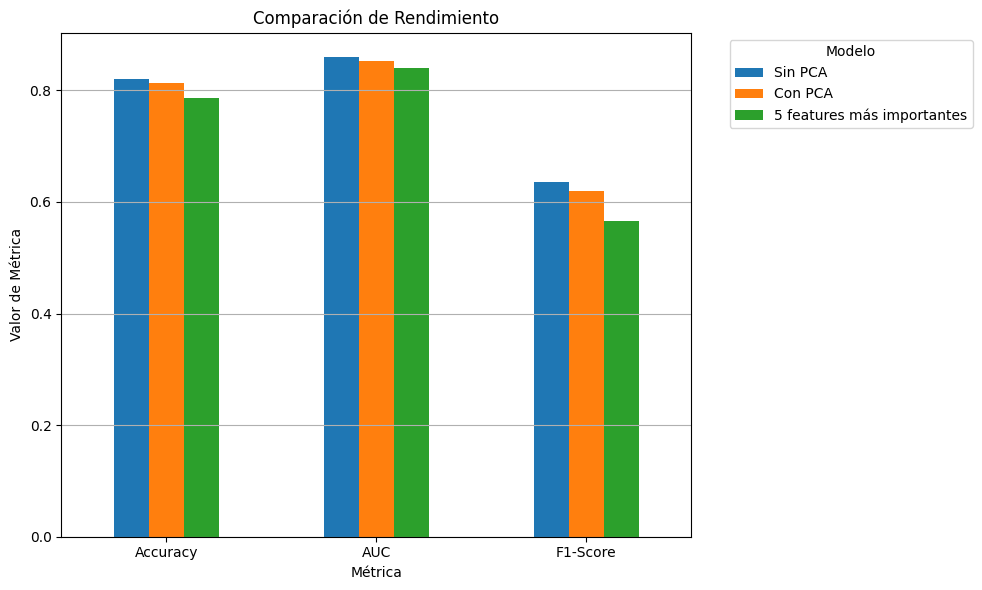

In [149]:
# Diccionario de modelos
modelos = {
	'Sin PCA': [best_log, X_val_transformed],
	'Con PCA': [logreg_pca, X_val_pca],
	'5 features más importantes': [logreg_reduced, X_val_reduced],
}

plot_metrics(modelos)

### Resultados observados:

| Métrica     | Sin PCA | Con PCA | Solo 5 Features |
|-------------|---------|---------|-----------------|
| Accuracy    | Más alto | Levemente menor | Menor        |
| AUC         | Más alto | Muy cercano     | Ligeramente inferior |
| F1-Score    | Más alto | Cercano         | Notablemente más bajo |

### Beneficios del uso de PCA:

- **Reducción de dimensionalidad automática**, sin necesidad de análisis de importancia manual.
- **Elimina colinealidad** entre variables al generar componentes ortogonales.
- Mejora el **rendimiento computacional** al reducir el número de dimensiones.

### Limitaciones del uso de PCA:

- **Pérdida de interpretabilidad**: las nuevas variables (componentes principales) no tienen un significado directo.
- **Puede conservar ruido** si no se escoge bien el umbral de varianza acumulada.
- En este caso, aunque el modelo con PCA mostró métricas **muy cercanas** al modelo completo, **no superó su desempeño**, y se pierde la posibilidad de explicar los resultados usando variables originales.


### En resumen:
Aunque PCA representa una buena alternativa para reducir dimensionalidad de forma automática, en este problema específico el modelo **sin reducción (todas las variables)** mantiene el **mejor rendimiento global** y una **interpretabilidad completa**.


# **8. Experimentation with t-SNE:**

- Investigate about the t-SNE, and explain the difference between t-SNE and PCA to reduce the dimensionality of the dataset.
- Use the reduced dataset to retrain the best ensemble model.
- Compare the performance of the model with PCA and t-SNE to the performance of the model without dimensionality reduction and the model with selected features. 

## 8.1 Explicación de t-SNE y comparación con PCA
- **PCA (Análisis de Componentes Principales)** es un método lineal que transforma los datos proyectándolos sobre nuevas dimensiones ortogonales (componentes principales), conservando la **máxima varianza**. Las variables resultantes pueden usarse directamente para modelos de predicción.

- **t-SNE (t-Distributed Stochastic Neighbor Embedding)** es un método no lineal y no supervisado que **no busca preservar varianza**, sino las **relaciones locales (vecindades)** entre puntos. Es ideal para **visualización**, pero **no es recomendable para entrenamiento de modelos supervisados**, porque:
  - No preserva distancias globales
  - No es transformable sobre nuevos datos (no tiene `.transform()` para test o validación)
  - Es computacionalmente costoso

## 8.2 Entrenamiento del modelo con t-SNE

In [132]:
from sklearn.manifold import TSNE

# Aplicar t-SNE para reducir a 2 componentes (por costumbre)
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000)
X_train_tsne = tsne.fit_transform(X_train_transformed)
X_val_tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000).fit_transform(X_val_transformed)

c:\Users\andy-\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\andy-\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


In [133]:
from sklearn.linear_model import LogisticRegression

logreg_tsne = LogisticRegression(
	C=best_log.C,
	penalty=best_log.penalty,
	solver=best_log.solver,
	max_iter=1000,
	random_state=42
)

logreg_tsne.fit(X_train_tsne, y_train)

LogisticRegression(C=100, max_iter=1000, random_state=42, solver='saga')

## 8.3 Comparación de métricas

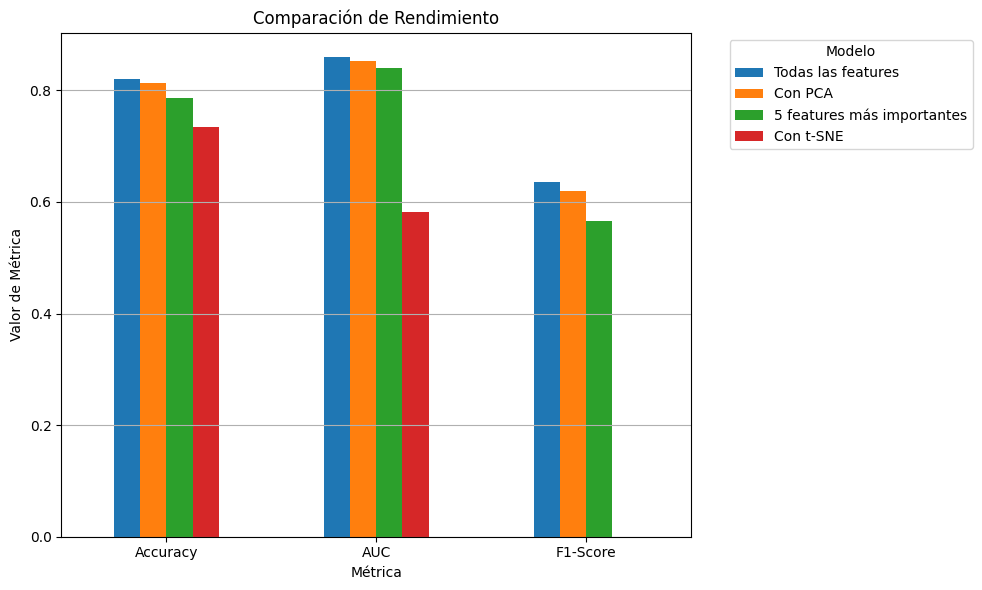

In [150]:
# Diccionario de modelos
modelos = {
	'Todas las features': [best_log, X_val_transformed],
	'Con PCA': [logreg_pca, X_val_pca],
	'5 features más importantes': [logreg_reduced, X_val_reduced],
	'Con t-SNE': [logreg_tsne, X_val_tsne],
}

plot_metrics(modelos)

Se compararon cuatro configuraciones del modelo de Regresión Logística, evaluadas sobre el conjunto de validación:

- **Modelo Completo**: Entrenado con todas las características transformadas (sin reducción).
- **Con PCA**: Reducción de dimensionalidad mediante Análisis de Componentes Principales (95% de varianza).
- **Solo 5 Features Importantes**: Seleccionadas con Random Forest + Hyperband.
- **Con t-SNE**: Reducción no lineal a 2 componentes usando t-SNE.

#### Resultados Observados

| Métrica     | Modelo Completo | Con PCA | Solo 5 Features | Con t-SNE |
|-------------|------------------|---------|------------------|------------|
| Accuracy    | Más alto       | Similar | Ligeramente menor| Significativamente menor |
| AUC         | Más alto       | Similar | Similar          | Mucho menor |
| F1-Score    | Más alto       | Similar | Menor            | Nulo |

#### Análisis de Rendimiento

- El **modelo completo** mantiene el mejor rendimiento en todas las métricas.
- **PCA** logra resultados muy similares, conservando estructura útil para clasificación y reduciendo dimensionalidad.
- El modelo con **5 features** tiene buen desempeño, pero cede precisión en F1-Score.
- **t-SNE**, aunque útil para visualización, muestra el rendimiento más bajo en Accuracy, AUC y F1-Score, demostrando que **no es adecuado para tareas de predicción supervisada**.

#### Consideraciones sobre t-SNE

- t-SNE no generaliza bien a nuevos datos (no tiene `.transform()`).
- Fue diseñado como herramienta de visualización, no de predicción.
- Requiere alto costo computacional y no garantiza estabilidad entre ejecuciones.

#### Conclusión

> El **modelo completo sin reducción** sigue siendo la mejor opción.  
> Aunque PCA ofrece una alternativa ligera y competitiva, y las 5 features son útiles para modelos simplificados, **t-SNE no resulta viable para predicción supervisada** debido a su naturaleza y bajo rendimiento observado en este contexto.


# **Elección del Modelo Final**

El modelo seleccionado como final es la **Regresión Logística entrenada con todas las características originales** (sin aplicar técnicas de reducción de dimensionalidad ni balanceo de clases con SMOTE).

#### Justificaciones:

1. **Desempeño superior en métricas clave**  
   En la comparación general, este modelo presentó los mejores resultados en **Accuracy, AUC y F1-Score**, superando a modelos con PCA, t-SNE, reducción a 5 features y ensamble de modelos. Esto indica que conserva mayor capacidad predictiva sin necesidad de simplificar la estructura del dataset.

2. **Simplicidad y bajo costo computacional**  
   La regresión logística es un modelo **lineal, rápido de entrenar y fácil de interpretar**, sin requerir arquitecturas complejas ni alto tiempo de cómputo. El entrenamiento completo tomó menos de 1 segundo.

3. **Mínimo procesamiento y preservación de información**  
   El modelo fue entrenado con un preprocesamiento muy básico (solo imputación y escalado), lo que permite mantener la **estructura original del dataset y el significado semántico de las variables**. Esto facilita futuras intervenciones, actualizaciones o auditorías.

4. **Interpretabilidad en el contexto de negocio**  
   Dado que las variables representan características reales de los clientes (como duración del contrato, cargos mensuales o servicios contratados), el modelo permite **extraer conclusiones útiles para la toma de decisiones**, como:
   - Qué tipo de contrato o servicio se asocia más con el abandono
   - Qué combinación de variables podría estar impulsando el churn
   - Cómo intervenir con estrategias focalizadas

5. **Evita sobreajuste por sobreingeniería**  
   Al no aplicar reducción como PCA o técnicas avanzadas como t-SNE (que podrían alterar la distribución o perder interpretabilidad), se conserva un buen equilibrio entre **precisión, interpretabilidad y simplicidad**.

#### Mejores hiperparámetros
- `max_iter`: 100
- `C`: 100
- `penalty`: l2
- `solver`: saga

---

### Conclusión

> Se elige el modelo de **Regresión Logística con todas las features y sin balanceo de clases** como el más adecuado por su **desempeño sólido, facilidad de uso, bajo costo computacional y alta interpretabilidad**, lo que lo convierte en una solución robusta y práctica para este problema de churn.

# **Evaluación Final del modelo ganador**

El modelo final seleccionado es el **Single Classifier (Regresión Logística)**, que ha demostrado ser el más eficiente y efectivo para este problema de clasificación binaria de churn. Este modelo ha mostrado las mejores métricas de rendimiento en términos de **Accuracy, AUC y F1-Score**, además de ser el más interpretativo y con menor costo computacional.

In [157]:
# Evaluar el modelo final
final_model = best_log
final_metrics = model_eval(final_model, X_test_transformed, y_test)

# Excluir la matriz de confusión para el DataFrame
final_metrics_scalar = {k: v for k, v in final_metrics.items() if k != 'Confusion Matrix'}
df_final_metrics = pd.DataFrame(final_metrics_scalar, index=[0])

print("\nMétricas del modelo final en el conjunto de test:")
print(df_final_metrics)


Métricas del modelo final en el conjunto de test:
   Accuracy       AUC  F1-Score
0  0.787083  0.832243  0.566474
